<h1 align="center">Predicting corn yields in the Corn Belt region of the USA using Machine Learning algorithms</h1> 

<h3 align="center">Capstone project by Leonardo Hernandez-Espinoza during the Spring 2019 TDI program at Oakland, CA</h3> 

## Objective: 

In this project I am looking at how weather affects corn yield in the corn belt of the United states.I compare three different models:<br> 
   - Ridge Regression
   - Random Forest Estimator
   - Support Vector Machine.
    

I compare the three modeling approaches and select the most important weather features in the prediction of corn yield. Once a <br>best model is found, I evaluate how the prediction varies under different climate change scenarios. 

## What is the Corn Belt?

The Corn Belt is a region of the Midwestern United states that, since the 1850s, has dominated corn production in the United states.<br>For this project I am includiing: Illinois, Indiana, Iowa, Kansas, Minnesota, Misouri, Nebraska, Ohio, and South Dakota.


<img src="cornbelt.jpg">

In [58]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [253]:
import math

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
from matplotlib import pyplot as plt
from sklearn import base
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from statsmodels.api import OLS

from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

<IPython.core.display.Javascript object>

In [77]:
%matplotlib inline
sns.set()
sns.set_style("white")
matplotlib.rcParams["figure.dpi"] = 150

<IPython.core.display.Javascript object>

## Data Collection:
The first part of this project was data collection. I obtained corn productivity data from the USDA National Agriculture Statistics Service<br>(https://quickstats.nass.usda.gov/). I am interested in corn productivity on a per area basis. Therefore, I used bushel per acre as the<br>productivity metric.

For climate data, I used the Climate Engine (https://app.climateengine.org/) to obtain climate data for the period between January 1990<br>and December 2018. Instead of using yearly climate data, I restricted the analysis to data that corresponds to the corn growing season.<br>For the corn belt region this is between the Julian days 100 and 305.

I gathered data for each of the nine states. To download the data from the Climate Engine I divided each state in quadrants<br>(to stay in the allowed download size). I combined the 36 files (9 states x 4 quadrants) into a pandas dataframe and then grouped by<br>year and state to calculate means (each data point corresponds to the average of the 4 quadrants).

Once I had the climate data, I created a new dataframe to include the productivity yield for each year in each state.<br>Here I am just importing that prepared dataset.

In [141]:
complete_data_df = pd.read_csv("complete_dataset.csv")

<IPython.core.display.Javascript object>

In [142]:
complete_data_df.head()

,year,state,prcp,srad,swe,tmax,tmin,vp,corn_yield
0,1990,Illinois,3.785194,367.596117,0.000000,24.704490,12.423544,1550.242718,129.2
1,1990,Indiana,4.137136,369.957282,0.000000,23.657160,11.640170,1463.786408,130.2
2,1990,Iowa,3.930825,357.565048,0.000000,23.706917,11.604976,1489.466019,130.2
3,1990,Kansas,2.703883,383.386408,0.000000,27.561893,13.749393,1670.922330,130.0
4,1990,Minnesota,3.192961,347.553399,0.514563,21.601942,8.559466,1197.669903,123.8


<IPython.core.display.Javascript object>

The dataframe includes the following columns: Year, state, Precipitaion (prcp), Solar radiation (srad), Snow water equivalent (SWE),<br>Maximum temperature (tmax), Minimum temperature (tmin), Vapor pressure (vp), and corn productivity (corn_yield).

A correlation matrix shows low correlation coefficients between corn productivity (yield) and the selected climate variables

In [143]:
corr = complete_data_df .corr()
corr.style.background_gradient().set_precision(2)


,year,prcp,srad,swe,tmax,tmin,vp,corn_yield
year,1.00,0.11,-0.09,0.05,0.11,0.16,0.13,0.64
prcp,0.11,1.00,-0.41,-0.10,0.01,0.41,0.53,0.32
srad,-0.09,-0.41,1.00,-0.18,0.70,0.34,0.19,-0.36
swe,0.05,-0.10,-0.18,1.00,-0.42,-0.38,-0.34,-0.00
tmax,0.11,0.01,0.70,-0.42,1.00,0.86,0.76,-0.10
tmin,0.16,0.41,0.34,-0.38,0.86,1.00,0.97,0.12
vp,0.13,0.53,0.19,-0.34,0.76,0.97,1.00,0.16
corn_yield,0.64,0.32,-0.36,-0.00,-0.10,0.12,0.16,1.00


<IPython.core.display.Javascript object>

## What is the relationship between corn productivity and the individual climate variables?

### Average maximum temperature

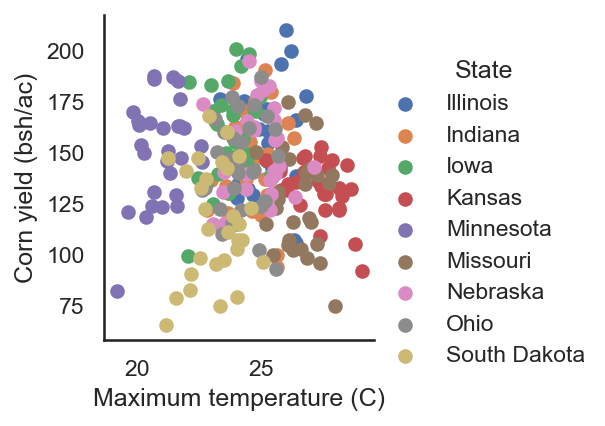

<IPython.core.display.Javascript object>

In [144]:
fg_tmax = sns.FacetGrid(complete_data_df, hue="state")
fg_tmax.map(plt.scatter, "tmax", "corn_yield").add_legend()
fg_tmax._legend.set_title("State")
fg_tmax.set(xlabel="Maximum temperature (C)", ylabel="Corn yield (bsh/ac)")
plt.show()

### Average minimum temperature

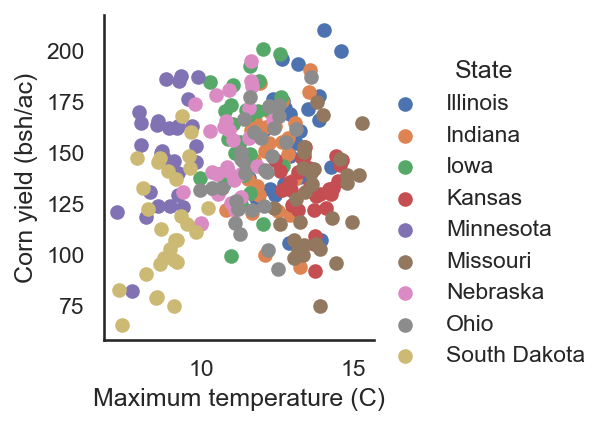

<IPython.core.display.Javascript object>

In [145]:
fg_tmin = sns.FacetGrid(complete_data_df, hue="state")
fg_tmin.map(plt.scatter, "tmin", "corn_yield").add_legend()
fg_tmin._legend.set_title("State")
fg_tmin.set(xlabel="Maximum temperature (C)", ylabel="Corn yield (bsh/ac)")
plt.show()

### Average daily precipitation

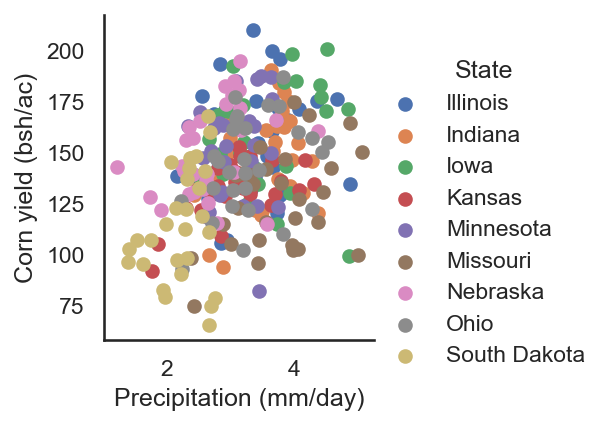

<IPython.core.display.Javascript object>

In [146]:
fg_precip = sns.FacetGrid(data=complete_data_df, hue="state")
fg_precip.map(plt.scatter, "prcp", "corn_yield").add_legend()
fg_precip._legend.set_title("State")
fg_precip.set(xlabel="Precipitation (mm/day)", ylabel="Corn yield (bsh/ac)")
plt.show()

### Vapor pressure

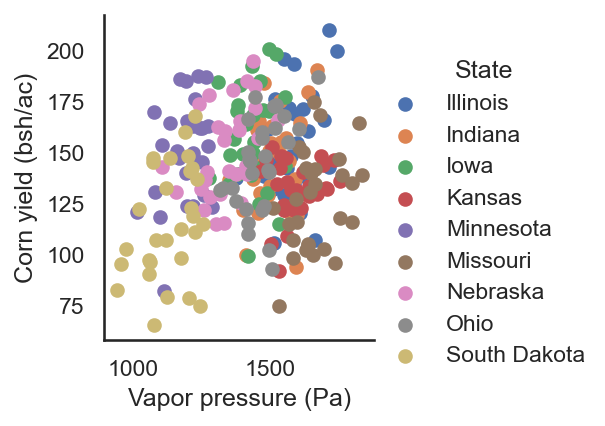

<IPython.core.display.Javascript object>

In [147]:
fg_vp = sns.FacetGrid(data=complete_data_df, hue="state")
fg_vp.map(plt.scatter, "vp", "corn_yield").add_legend()
fg_vp._legend.set_title("State")
fg_vp.set(xlabel="Vapor pressure (Pa)", ylabel="Corn yield (bsh/ac)")
plt.show()

### Snow water equivalent

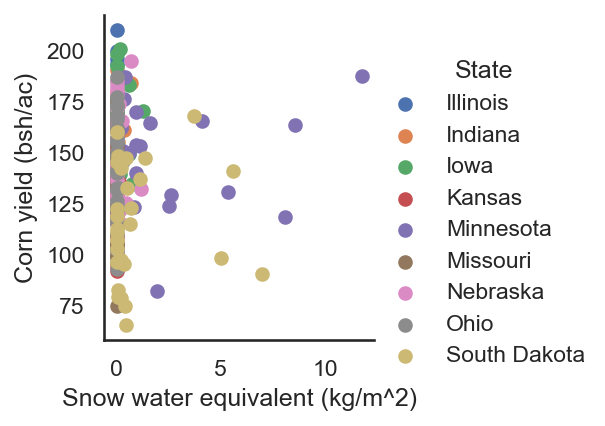

<IPython.core.display.Javascript object>

In [148]:
fg_swe = sns.FacetGrid(data=complete_data_df, hue="state")
fg_swe.map(plt.scatter, "swe", "corn_yield").add_legend()
fg_swe._legend.set_title("State")
fg_swe.set(xlabel="Snow water equivalent (kg/m^2)", ylabel="Corn yield (bsh/ac)")
plt.show()

### Solar radiation

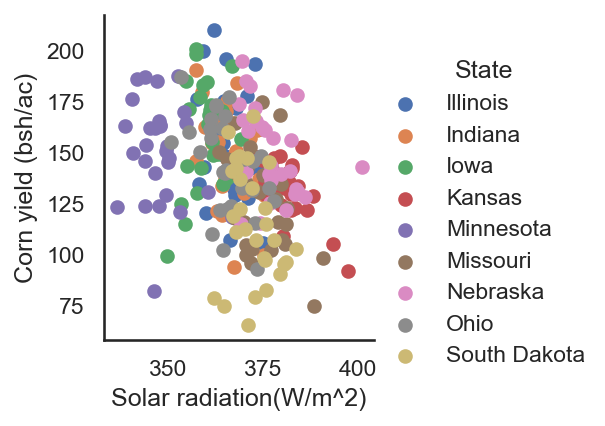

<IPython.core.display.Javascript object>

In [149]:
fg_srad = sns.FacetGrid(data=complete_data_df, hue="state")
fg_srad.map(plt.scatter, "srad", "corn_yield").add_legend()
fg_srad._legend.set_title("State")
fg_srad.set(xlabel="Solar radiation(W/m^2)", ylabel="Corn yield (bsh/ac)")
plt.show()

# Modeling approaches

The fist approach was to evaluate a model including as many variables as possible. In this case I created a set of models to estimate corn production in response to temperature (maximum and minimum), Precipitation, Vapor pressure, solar radiation, and Snow Water Equivalent. I used three different models: Ridge Regression, Random Forest Regressors, and Support Vector Machine

### Split the data in train and test

To train the model we are using data for the period 1990 to 2010 and to test the models we are using data for the period 2011 to 2018

In [159]:
train_data_df = complete_data_df.query("year<=2010")
test_data_df = complete_data_df.query("year>2010")

<IPython.core.display.Javascript object>

In [160]:
Observed_yields = test_data_df['corn_yield'].tolist()


<IPython.core.display.Javascript object>

# Full Models

## Ridge Regression

I used ColumnSelectTransformer to select which columns are going to be be used in the Ridge regression model via a pipeline

In [156]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()

    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self

    def transform(self, X):
        return X[self.col_names]

        # Return an array with the same number of rows as X and one
        # column for each in self.col_names

<IPython.core.display.Javascript object>

The pipeline is defined as:

In [233]:
ridge_est = Ridge()
corn_pipe_ridge = Pipeline(
    [
        (
            "cols_selct",
            ColumnSelectTransformer(["tmax", "tmin", "prcp", "srad", "swe", "vp"]),
        ),
        ("ridge", ridge_est),
    ]
)

<IPython.core.display.Javascript object>

To train the model I use the data training data (1990 to 2010)

In [234]:
target = train_data_df[["corn_yield"]]

<IPython.core.display.Javascript object>

In [235]:
corn_pipe_ridge.fit(train_data_df, target)

Pipeline(steps=[('cols_selct',
                 ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp',
                                                    'srad', 'swe', 'vp'])),
                ('ridge', Ridge())])

<IPython.core.display.Javascript object>

In [236]:
predited_ridge = corn_pipe_ridge.predict(test_data)

<IPython.core.display.Javascript object>

In [237]:
MSE2 = mean_squared_error(Observed_yields, predited_ridge.flatten())
RMSE2 = math.sqrt(MSE2)
RMSE2

34.555323082996374

<IPython.core.display.Javascript object>

In [265]:
obs_pred_ridge_df = pd.DataFrame(list(zip(Observed_yields, predited_ridge.flatten())), 
               columns =['Observed', 'Predicted']) 


<IPython.core.display.Javascript object>

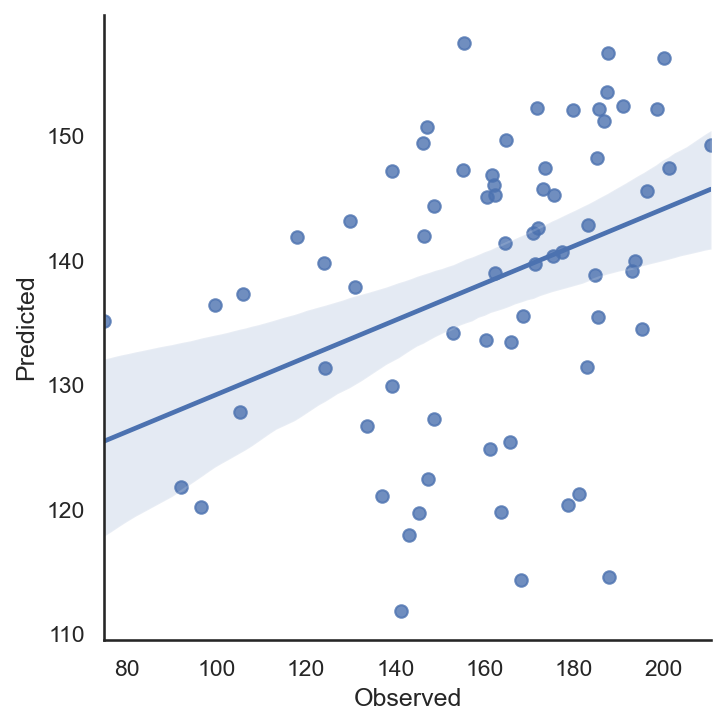

<IPython.core.display.Javascript object>

In [266]:
sns.lmplot(x="Observed", y="Predicted", data=obs_pred_ridge_df, fit_reg=True)
plt.show()

In [240]:
X2 = obs_pred_ridge[["Observed"]]
y2 = obs_pred_ridge[["Predicted"]]
ridge_ols = OLS(y2, X2).fit()
ridge_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Predicted   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              2594.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):                    1.22e-57
Time:                        22:14:59   Log-Likelihood:                         -326.82
No. Observations:                  72   AIC:                                      655.6
Df Residuals:                      71   BIC:                                      657.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8399      0.016     50.932      0.000       0.807       0.873
==============================================================================
Omnibus:                        5.412   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                4.810
Skew:                           0.623   Prob(JB):                       0.0903
Kurtosis:                       3.223   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Random forest estimator

In [243]:
rf = RandomForestRegressor()
corn_pipe_rf = Pipeline(
    [
        (
            "cols_selct",
            ColumnSelectTransformer(["tmax", "tmin", "prcp", "srad", "swe", "vp"]),
        ),
        ("RFR", rf),
    ]
)

<IPython.core.display.Javascript object>

In [244]:
corn_pipe_rf.fit(train_data_df, target)

Pipeline(steps=[('cols_selct',
                 ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp',
                                                    'srad', 'swe', 'vp'])),
                ('RFR', RandomForestRegressor())])

<IPython.core.display.Javascript object>

In [246]:
predicted_rf = corn_pipe_rf.predict(test_data)

<IPython.core.display.Javascript object>

In [268]:
obs_pred_rf_df = pd.DataFrame(
    list(zip(Observed_yields, predicted_rf.flatten())),
    columns=["Observed", "Predicted"],
)

<IPython.core.display.Javascript object>

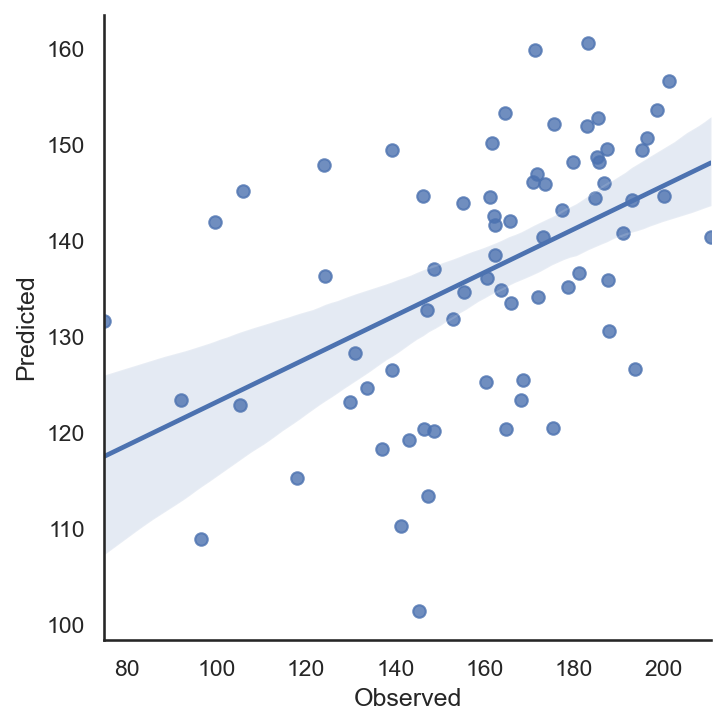

<IPython.core.display.Javascript object>

In [269]:
sns.lmplot(x="Observed", y="Predicted", data=obs_pred_rf_df, fit_reg=True)
plt.show()

In [250]:
MSE = mean_squared_error(Observed_yields, predicted_rf.flatten())

<IPython.core.display.Javascript object>

In [251]:
RMSE = math.sqrt(MSE)
RMSE

34.24335261850911

<IPython.core.display.Javascript object>

In [252]:
X3 = obs_pred_rf[["Observed"]]
y3 = obs_pred_rf[["Predicted"]]
rf_ols = OLS(y3, X3).fit()
rf_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Predicted   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              3006.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):                    7.46e-60
Time:                        22:25:53   Log-Likelihood:                         -320.96
No. Observations:                  72   AIC:                                      643.9
Df Residuals:                      71   BIC:                                      646.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8335      0.015     54.823      0.000       0.803       0.864
==============================================================================
Omnibus:                       14.339   Durbin-Watson:                   1.185
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.001
Skew:                           0.987   Prob(JB):                     0.000335
Kurtosis:                       4.197   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## SVM 

In [254]:
est = svm.SVR(kernel="rbf", gamma="auto")
corn_pipe_svm = Pipeline(
    [
        (
            "cols_selct",
            ColumnSelectTransformer(["tmax", "tmin", "prcp", "srad", "swe", "vp"]),
        ),
        ("svm", est),
    ]
)

<IPython.core.display.Javascript object>

In [255]:
corn_pipe_svm.fit(train_data_df, target)

Pipeline(steps=[('cols_selct',
                 ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp',
                                                    'srad', 'swe', 'vp'])),
                ('svm', SVR(gamma='auto'))])

<IPython.core.display.Javascript object>

In [256]:
predicted_svm = corn_pipe_SVM.predict(test_data)

<IPython.core.display.Javascript object>

In [258]:
obs_pred_svm_df = pd.DataFrame(
    list(zip(Observed_yields, predicted_svm.flatten())),
    columns=["Observed", "Predicted"],
)

<IPython.core.display.Javascript object>

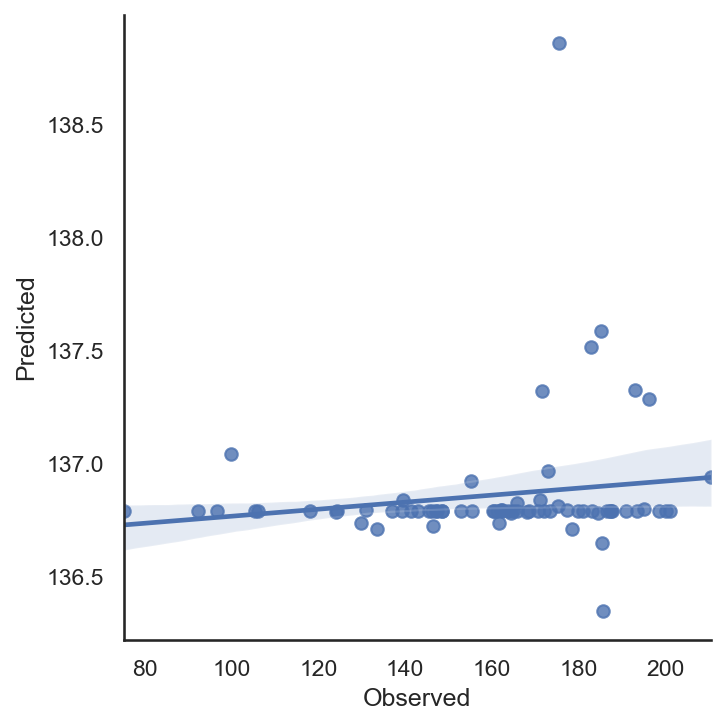

<IPython.core.display.Javascript object>

In [259]:
sns.lmplot(x="Observed", y="Predicted", data=obs_pred_svm_df, fit_reg=True)
plt.show()

In [263]:
MSE = mean_squared_error(Observed_yields, predicted_svm.flatten())
RMSE = math.sqrt(MSE)
RMSE

36.94992700511702

<IPython.core.display.Javascript object>

In [264]:
X4 = obs_pred_svm_df[["Observed"]]
y4 = obs_pred_svm_df[["Predicted"]]
svm_ols = OLS(y4, X4).fit()
svm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Predicted   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              2270.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):                    1.23e-55
Time:                        22:36:34   Log-Likelihood:                         -330.49
No. Observations:                  72   AIC:                                      663.0
Df Residuals:                      71   BIC:                                      665.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8268      0.017     47.642      0.000       0.792       0.861
==============================================================================
Omnibus:                        8.864   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.632
Skew:                           0.827   Prob(JB):                       0.0134
Kurtosis:                       3.375   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Comparison of Three Full Models

In [274]:
# Create a new DF with all the predicted v Observed
obs_pred_ridge_df["Model"] = "Ridge"
obs_pred_rf_df["Model"] = "RFR"
obs_pred_svm_df["Model"] = "SVM"

<IPython.core.display.Javascript object>

In [279]:
all_models = pd.concat([obs_pred_ridge_df, obs_pred_rf_df, obs_pred_svm_df])

<IPython.core.display.Javascript object>

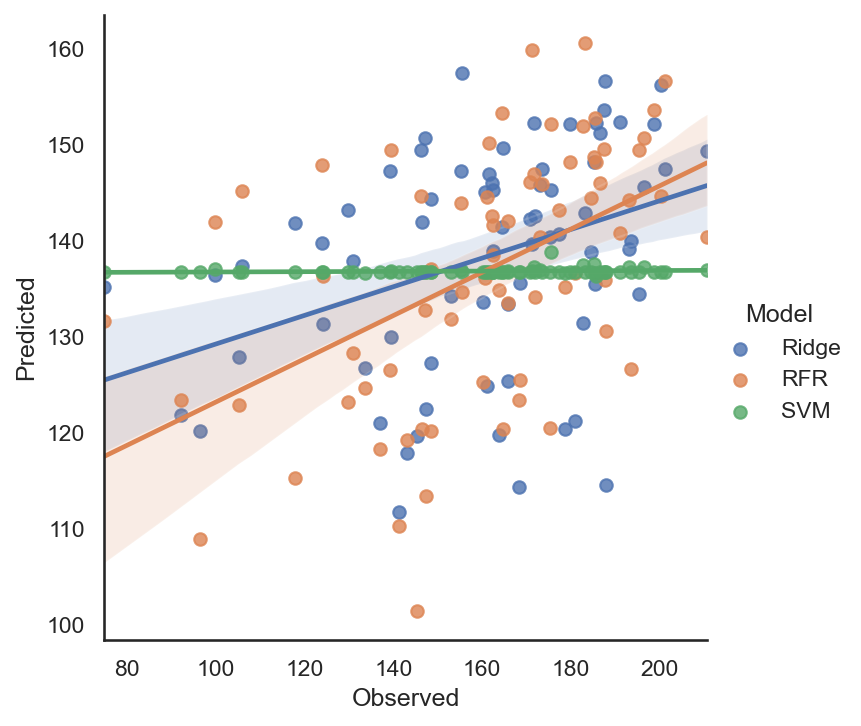

<IPython.core.display.Javascript object>

In [280]:
# sns.set_style("white")
sns_plot = sns.lmplot(
    x="Observed", y="Predicted", hue="Model", data=all_models, fit_reg=True
)
# sns_plot.savefig("fullmodels.png")

The comparison of the three plots shows that SVM is the worst performing out of the three considered models. SVM is predicting the same production yield ~139 bu/ac of corn for every observed yield. The two remaining models have very similar performance both in terms of AIC and $R^{2}$. However, the ridge regression model has the lowest RMSE (33.85 vs 35.53).

# Reduced Models

The next step was to find a more parsimonious model. To achieve this, I compared the same three models (*i.e*. Ridge Regression, Random Forest Regressor, and SVM). But in this case I only considered Temperature (max and min) and Precipitation as features in the models.

## Ridge

In [60]:
ridge_est = Ridge()  
corn_pipe = Pipeline([
        ('cols_selct', ColumnSelectTransformer(['tmax', 'tmin','prcp'])), 
        ('ridge', ridge_est)
    ])

In [61]:
corn_pipe.fit(complete_data_df , production)

Pipeline(memory=None,
     steps=[('cols_selct', ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp'])), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [62]:
predichos1 = corn_pipe.predict(test_data)

In [63]:
predichos=[]
for line in predichos1:
        predichos.append(float(line))



In [64]:
New_df = pd.DataFrame(list(zip(Observed_yields, predichos)), 
               columns =['Observed', 'Predicted']) 

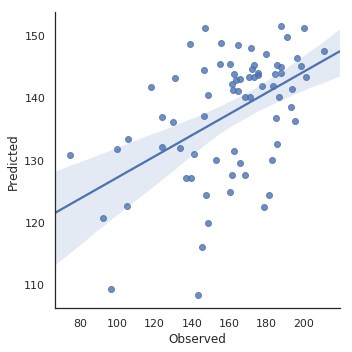

In [65]:
import seaborn as sns
sns.lmplot(x='Observed',y='Predicted',data=New_df,fit_reg=True) 

In [66]:
MSE = mean_squared_error(Observed_yields,predichos)

In [67]:
RMSE = math.sqrt(MSE)
RMSE

34.103617357922516

In [68]:
X = New_df[['Observed']]
y = New_df[['Predicted']]
model2 = OLS(y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Predicted   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2975.
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.06e-59
Time:                        15:41:43   Log-Likelihood:                -321.49
No. Observations:                  72   AIC:                             645.0
Df Residuals:                      71   BIC:                             647.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8353      0.015     54.545      0.000       0.805       0.866
==============================================================================
Omnibus:                        6.849   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.519
Skew:                           0.733   Prob(JB):                       0.0384
Kurtosis:                       3.163   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Because the difference in RMSE and AIC between the six and the three features models is very small, we choose the model eith the fewer features: Maximum temperature, Minimum temperature, and Precipitaion

## Random Forest Regresor

In [69]:
rf = RandomForestRegressor() 
corn_pipe3_RFR = Pipeline([
        ('cols_selct', ColumnSelectTransformer(['tmax', 'tmin','prcp'])), 
        ('RFR', rf)
    ])

In [70]:
corn_pipe3_RFR.fit(complete_data_df , production)

Pipeline(memory=None,
     steps=[('cols_selct', ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp'])), ('RFR', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [71]:
predichos1_RFR = corn_pipe3_RFR.predict(test_data)
predichos1_RFR 

array([137.26, 151.18, 157.34, 133.36, 126.02, 111.28, 147.94, 160.62,
       114.24, 134.24, 137.84, 137.48, 133.36, 146.3 , 130.72, 122.4 ,
       156.2 , 114.7 , 131.62, 152.78, 145.22, 125.66, 144.82, 135.64,
       140.98, 141.74, 129.64, 148.32, 135.4 , 153.72, 125.74, 145.18,
       115.32, 149.42, 159.82, 119.94, 135.92, 143.76, 148.18, 124.82,
       145.42, 144.48, 159.72, 127.76, 124.62, 137.74, 151.38, 150.08,
       118.58, 145.18, 111.6 , 152.78, 135.72, 131.24, 124.74, 146.36,
       148.84, 119.4 , 133.56, 108.66, 149.18, 138.64,  94.82, 141.4 ,
       142.64, 167.76, 132.86, 140.56, 134.8 , 148.86, 149.92, 117.12])

In [72]:
predichos3_RFR=[]
for line in predichos1_RFR:
        predichos3_RFR.append(float(line))



In [73]:
len(predichos3_RFR)

72

In [74]:
New_df_3RF = pd.DataFrame(list(zip(Observed_yields, predichos1_RFR)), 
               columns =['Observed', 'Predicted']) 

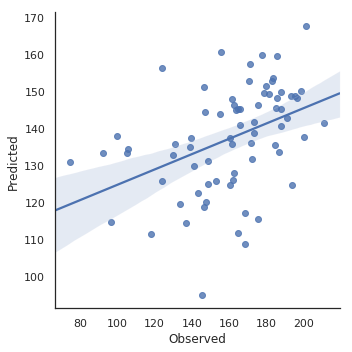

In [75]:
sns.lmplot(x='Observed',y='Predicted',data=New_df_3RF ,fit_reg=True) 

In [76]:
MSE = mean_squared_error(Observed_yields,predichos3_RFR)

In [77]:
RMSE = math.sqrt(MSE)
RMSE

34.84870404492986

In [78]:
X = New_df_3RF[['Observed']]
y = New_df_3RF[['Predicted']]
model2 = OLS(y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Predicted   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2659.
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           5.18e-58
Time:                        15:41:49   Log-Likelihood:                -325.54
No. Observations:                  72   AIC:                             653.1
Df Residuals:                      71   BIC:                             655.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8355      0.016     51.569      0.000       0.803       0.868
==============================================================================
Omnibus:                        7.842   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.222
Skew:                           0.724   Prob(JB):                       0.0270
Kurtosis:                       3.556   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SVM

In [79]:
est = svm.SVR(kernel='rbf',gamma='auto')
corn_pipe_SVM3 = Pipeline([
        ('cols_selct', ColumnSelectTransformer(['tmax', 'tmin','prcp'])), 
        ('svm', est)
    ])

In [80]:
corn_pipe_SVM3.fit(complete_data_df , production)

Pipeline(memory=None,
     steps=[('cols_selct', ColumnSelectTransformer(col_names=['tmax', 'tmin', 'prcp'])), ('svm', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [81]:
predicted_SVM3 = corn_pipe_SVM3.predict(test_data)

In [82]:
predichos_SVM3_1=[]
for line in predicted_SVM3 :
        predichos_SVM3_1.append(float(line))


In [83]:
New_df_SVM3 = pd.DataFrame(list(zip(Observed_yields, predichos_SVM3_1)), 
               columns =['Observed', 'Predicted']) 

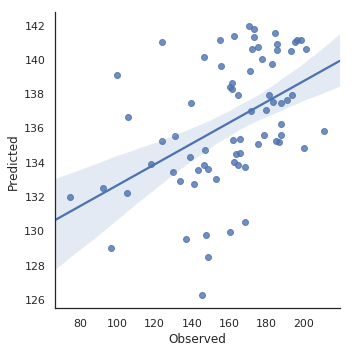

In [84]:
sns.lmplot(x='Observed',y='Predicted',data=New_df_SVM3,fit_reg=True) 

In [85]:
MSE = mean_squared_error(Observed_yields,predichos_SVM1)

In [86]:
RMSE = math.sqrt(MSE)
RMSE

36.94992700557016

In [87]:
X4 = New_df_SVM3[['Observed']]
y4 = New_df_SVM3[['Predicted']]
model2 = OLS(y4,X4).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Predicted   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     2579.
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           1.50e-57
Time:                        15:41:56   Log-Likelihood:                -325.77
No. Observations:                  72   AIC:                             653.5
Df Residuals:                      71   BIC:                             655.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Observed       0.8254      0.016     50.782      0.000       0.793       0.858
==============================================================================
Omnibus:                       10.120   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.037
Skew:                           0.875   Prob(JB):                      0.00661
Kurtosis:                       3.535   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Comparing the Three Reduced Models

In [88]:
New_df2['Model']='Ridge'
New_df_3RF['Model']='RFR'
New_df_SVM3['Model']='SVM'
Reduced_model = pd.concat([New_df2, New_df_3RF,New_df_SVM3 ])

In [89]:
export_csv = Reduced_model.to_csv (r'Reduced_model.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

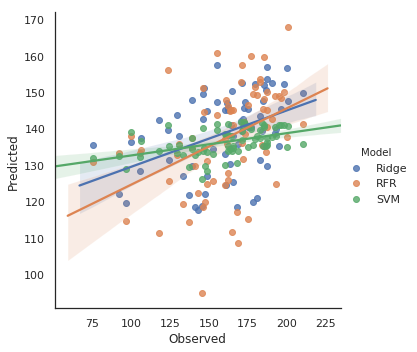

In [90]:
sns_plot = sns.lmplot(x='Observed',y='Predicted',hue='Model', data=Reduced_model,fit_reg=True) 
sns_plot.savefig("reducedmodels.png")


In the case of the reduced models, the performance was similar to that of the full models. Ridge regression was the best performing of the three considered models. Ridge Regression was the lowest RMSE and AIC, as well as the highest $R_{2}$. It is important to notice that the difference between the full and the reduced models is minimal, therefore the more parsimonious (fewer features) model will be used to estimate future corn productivity.

# Future corn productivity estimation

## How is the climate expected to change?

Import the estimated future climate data. This data set includes the estimated mean temperature (max and min) and precipitation for each of the nine states in the corn belt. The series includes data for the period of time between 2019 and 2050.

The two climate changes scenarios I am considering here are: RCP4.5 and RCP8.5 (RCP4 & RCP8 hereafter). These are averaged models than summarize information from 30 individual climate change models that are included in the 5th Climate Model Intercomparison Program (CIMP5).

RCP4 is the most likely scenario and it is the equivalent of reaching a greenhouse gas concentration that stabilizes so that we do not to exceed a radiative equivalent of 4.5 Wm-2 after 2100. That would be the equivalent of 650 ppm CO2, a 250 ppm increase over the current global average. RCP8 is a more aggressive scenario. It is the equivalent of a 1370 ppm CO2 which would lead to a 8.5 Wm-2 radiative equivalence.  For more information about the models please visit (https://www2.usgs.gov/landresources/lcs/nccv.asp)


### Import data

In [91]:
future_climate = pd.read_csv('Future_climate3.csv')

In [92]:
future_climate.head()

,Year,State,RCP4_Tmax,RCP4_Tmin,RCP4_Precip,RCP8_Tmax,RCP8_Tmin,RCP8_Precip
0,2019,Illinois,26.542143,13.406429,90.617000,26.806714,13.661571,86.324143
1,2019,Indiana,25.968286,12.729429,94.128286,26.240429,12.999429,92.010429
2,2019,Iowa,25.234571,12.032000,93.734857,25.367857,12.200857,86.615571
3,2019,Kansas,28.891429,13.850429,74.711286,28.749429,13.857571,75.639714
4,2019,Minnesota,22.390571,8.958286,79.235429,22.250571,9.030429,78.829286


Next step is to create two test data sets, one for each climate change scenario

In [93]:
RCP4_test = future_climate[['Year','state','RCP4_Tmax', 'RCP4_Tmin','RCP4_Precip']]
RCP8_test = future_climate[['Year','state','RCP8_Tmax', 'RCP8_Tmin','RCP8_Precip']]

In [94]:
nombres2 = ['year',
 'state',
 'tmax',
 'tmin',
 'prcp']

In [95]:
RCP4_test.columns = nombres2
RCP8_test.columns = nombres2

Once I have the predicted future climate data I will use the ridge regression model to predict corn yield using temperature (max and min) and precipitation.

In [96]:
predicted_RCP4_1 = corn_pipe.predict(RCP4_test)
predicted_RCP8_1 = corn_pipe.predict(RCP8_test)

### Next steps are a set of data organization and formating to create a final dataframe that inlcudes Year, Productivity, and Scenario used

In [97]:
predicted_RCP4=[]
for line in predicted_RCP4_1:
        predicted_RCP4.append(float(line))

In [98]:
predicted_RCP8=[]
for line in predicted_RCP8_1:
        predicted_RCP8.append(float(line))

Create a new data frame that includes year, state, predicted, and scenario (RCP4 or RCP8)

In [99]:
Future_production_1 = future_climate[['Year','state']]

In [100]:
len(predicted_RCP4)

288

In [101]:
Future_production_1['Predicted'] = predicted_RCP4

In [102]:
Future_production_1['Scenario']='RCP4'

In [103]:
Future_production_2 = future_climate[['Year','state']]

In [104]:
Future_production_2['Predicted'] = predicted_RCP8

In [105]:
Future_production_2['Scenario']='RCP8'

In [106]:
Future_production_2.shape

(288, 4)

In [107]:
Future_production = pd.concat([Future_production_1,Future_production_2 ])

In [108]:
Future_production.head()

,Year,State,Predicted,Scenario
0,2019,Illinois,54.437366,RCP4
1,2019,Indiana,49.146288,RCP4
2,2019,Iowa,48.666935,RCP4
3,2019,Kansas,54.503824,RCP4
4,2019,Minnesota,55.420329,RCP4


In [109]:
Future_production.dtypes

Year           int64
State         object
Predicted    float64
Scenario      object
dtype: object

In [110]:
export_csv =Future_production.to_csv (r'Future_production.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

## Comparison of estimated corn productivity under two different climate change scenarios

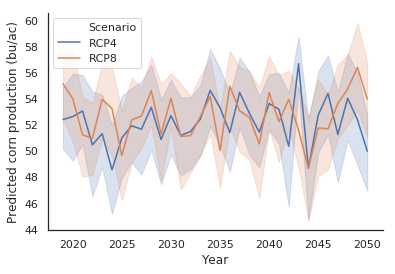

In [111]:

ax = sns.lineplot(x="Year", y="Predicted", hue="Scenario", data=Future_production)
ax.set(xlabel='Year', ylabel='Predicted corn production (bu/ac)')
sns.despine()
sns_plot.savefig("future_production.png")
plt.show()

# Conclusion

As the consequences of climate change become more evident, we need to prepare our food production systems to be resilient to those changes. The US is the world largest corn producer in the world, and approximately 75% of the production comes from the corn belt region. 
In this study I limited my models to three important climate variables: maximum temperature, minimum temperature, and precipitation. Not only because these variables have been shown to directly impact plant productivity but also because they included in most climate change models. Using the RCP4 and RCP8 averaged models I found very similar predictions in corn productivity. One possible explanation for the lack of response to increased temperatures is the fact that corn has what is known as a C4 photosynthesis pathway. Plants with this pathway have anatomical and biochemical adaptations that allow the plant to function and thrive under warm weather conditions. Therefore, it is possible that as climate in the corn belt increases, the conditions would become even more favorable for this crop.
Nonetheless, I only considered three environmental variables, and a more exhaustive exploration is needed. To better predict how climate change would impact corn production, we need to explore how other processes would be impacted by climate change. For example, even if there are no changes in predicted average precipitation, the timing and frequency of rain would have serious implications, as seen by the severe floods that occurred this year in parts of the corn belt.
Asides from the climate variables, human processes may also impact future corn productivity. From market forces to the policies that maintain government subsidies. As we move forward, we need a more comprehensive approach to better understand how corn productivity will be impacted by climate change. 


# Future directions

The next steps I will be taking with this analysis include a more detailed evaluation of different climate variables in the predictive power of the models. I will be splitting the growing season in two. The idea is to evaluate if the climate condition in the first 100 days of the growing season (when plants are stablishing) and in the last 100 days of the growing season (grain filling stage) have a differential effect on the estimated corn productivity.

# About Me

I am a plant eco-physiologist by training and a problem solver by nature. As plant ecologist I work on complex systems, and I am interested in the relationships between the physical environment and the performance and distribution of plants. As a plant physiologist I am interested in mechanisms behind plant responses. Because natural systems tend to be noisy, I have developed a strong interest in statistical analysis such as: Hypothesis Testing, Causal Inference, Regression Analysis, Mixed Effect Models, as a way to gain insight from data. As a data scientist I am interested in predictive modeling using machine learning approaches. I want to focus on the development of models with high predictive power while maintaining high explainability as a way to effectively transfer knowledge and further the understanding of data.

## Email:

    hernandez.leo@gmail.com 
    
## LinkdIn:
    https://www.linkedin.com/in/hernandez-leo/